##### This script will associate spoken phrases with their corresponding translation, using a convolutional neural network ("CNN")

I am going to start by using subset of a few phrases I chose manually from Female 1. (index_TORGO_test.txt)

In [3]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [53]:
# Load index of test data

# *** Load prompt_id as text with leading zeros
# *** Make sure when implemented on larger dataset, to ignore where prompt is None and where has_spect is No

df = pd.read_csv('index_TORGO_test.txt', sep=",", converters={'prompt_id': lambda x: str(x)})

# Add numerical prompt codes
df.prompt = pd.Categorical(df.prompt)
df['prompt_code'] = df.prompt.cat.codes

df.head(20)

,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,prompt_code
0,F01,Session1,wav_headMic,0014,yes,206,513,he slowly takes a short walk in the open air e...,6
1,F01,Session1,wav_headMic,0015,yes,67,513,air,3
2,F01,Session1,wav_headMic,0018,yes,65,513,no,8
3,F01,Session1,wav_headMic,0020,yes,153,513,Usually minus several buttons.,2
4,F01,Session1,wav_headMic,0024,yes,53,513,knee,7
5,F01,Session1,wav_headMic,0025,yes,73,513,feet,5
6,F01,Session1,wav_headMic,0031,yes,145,513,The quick brown fox jumps over the lazy dog.,1
7,F01,Session1,wav_headMic,0032,yes,237,513,She had your dark suit in greasy wash water al...,0
8,F01,Session1,wav_headMic,0046,yes,44,513,chair,4
9,F01,Session1,wav_headMic,0075,yes,43,513,warm,9


### 1) Pad Images

This model will rely on the spectrogram images we generated from each audio file. I believe the CNN requires these images to be the same size. They are currenly all the same height (frequency axis), but are not the same width (time axis). Therefore, I will pad the end of each image so that all of the images are also the same width - using the max width of all the images.

Further research suggests that the images should be squares, and dimensions should be an even number since they may be divided by two one or twice. I will pad the bottom of the y axis (frequency) with a replication of what is above it, that way the information is still useful for prediction, rather than just padding it with gray like the x axis (time) axis.

[Tutorial for Padding with OpenCV](https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html)

In [13]:
# Get max width / height, which all images will be padded up to on both axis to make a square
# Force it to be an even number, and able to be divided by 2 twice

maxwidth = df['spect_width'].max()
maxheight = df['spect_height'].max()

if maxwidth <= maxheight:
    maxwidth = maxheight

if maxwidth % 2 == 1:
    maxwidth += 1

if maxwidth/4 != 0:
    maxwidth += 2
    
print(maxwidth)

516


Shape before: (513, 206, 3)
Shape after: (516, 516, 3)


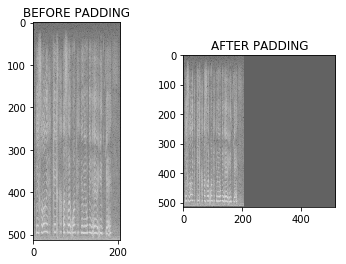

In [16]:
# View example of before and after padding
img_loc = '/'.join(['../data/TORGO', df['speaker'][0], df['session'][0], df['mic'][0]+'_spect', df['prompt_id'][0]+'.png'])

# Image before padding
img = cv2.imread(img_loc)
imgplot = plt.subplot(121),plt.imshow(img),plt.title('BEFORE PADDING')
print('Shape before:', img.shape)

# Image after padding
pad = maxwidth - img.shape[1] # pad width with gray
img_new = cv2.copyMakeBorder(img,0,0,0,pad,cv2.BORDER_CONSTANT,value=[98,98,98])
pad = maxwidth - img.shape[0] # pad height with replication
img_new = cv2.copyMakeBorder(img_new,0,pad,0,0,cv2.BORDER_WRAP)
print('Shape after:', img_new.shape)

imgplot_new = plt.subplot(122),plt.imshow(img_new),plt.title('AFTER PADDING')

In [54]:
# Get all predictor variables (padded images) and outcome variable (prompt)
x = []
y = []

for index, row in df.iterrows(): 
    img_loc = '/'.join(['../data/TORGO', row['speaker'], row['session'], row['mic']+'_spect', row['prompt_id']+'.png'])
    img = cv2.imread(img_loc)
    pad = maxwidth - img.shape[1] # pad width with gray
    img_new = cv2.copyMakeBorder(img,0,0,0,pad,cv2.BORDER_CONSTANT,value=[98,98,98])
    pad = maxwidth - img.shape[0] # pad height with replication
    img_new = cv2.copyMakeBorder(img_new,0,pad,0,0,cv2.BORDER_WRAP)
    x.append(img_new)
    y.append(row['prompt_code'])  

In [55]:
# View first 10 records, and verify images are all the same size now
print(y[0:10])

for i in x[0:10]:
    print(i.shape)

[6, 3, 8, 2, 7, 5, 1, 0, 4, 9]
(516, 516, 3)
(516, 516, 3)
(516, 516, 3)
(516, 516, 3)
(516, 516, 3)
(516, 516, 3)
(516, 516, 3)
(516, 516, 3)
(516, 516, 3)
(516, 516, 3)


### 2) Set up CNN

First will attempt CNN using Keras. [See here](https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/)

After that may attempt to replicate [This Project](https://mabelvj.github.io/capstone_mabelvj/)

##### TensorFlow - I think almost works but decided to use Keras

In [21]:
# # The code above has been edited to assume it runs a single batch each time. In our text example a batch of size 10

# # optimizers
# learning_rate = 0.0001
# epochs = 10
# batch_size = 10
# pixels = maxwidth * maxwidth

# # declare the training data placeholders
# # input x - for length x width = total pixels - this is the flattened image data
# x = tf.placeholder(tf.float32, [None, pixels])
# # reshape the input data so that it is a 4D tensor.  The first value (-1) tells function to dynamically shape that
# # dimension based on the amount of data passed to it.  The two middle dimensions are set to the image size (i.e. l
# # x w).  The final dimension is 1 if single colour channel i.e. grayscale, or 3 if this was RGB. In our case 3.
# x_shaped = tf.reshape(x, [-1, maxwidth, maxwidth, 3])
# # now declare the output data placeholder - HARDCODING THIS TO 10 SINCE TEST DATA HAS 10 RECORDS AND 10 UNIQUE PROMPTS
# y = tf.placeholder(tf.float32, [None, 10])

# def create_new_conv_layer(input_data, num_input_channels, num_filters, filter_shape, pool_shape, name):
#     # setup the filter input shape for tf.nn.conv_2d
#     conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]

#     # initialise weights and bias for the filter
#     weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03), name=name+'_W')
#     bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

#     # setup the convolutional layer operation
#     out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')

#     # add the bias
#     out_layer += bias

#     # apply a ReLU non-linear activation
#     out_layer = tf.nn.relu(out_layer)

#     # now perform max pooling
#     # ksize is the argument which defines the size of the max pooling window (i.e. the area over which the maximum is
#     # calculated).  It must be 4D to match the convolution - in this case, for each image we want to use a 2 x 2 area
#     # applied to each channel
#     ksize = [1, pool_shape[0], pool_shape[1], 1]
#     # strides defines how the max pooling area moves through the image - a stride of 2 in the x direction will lead to
#     # max pooling areas starting at x=0, x=2, x=4 etc. through your image.  If the stride is 1, we will get max pooling
#     # overlapping previous max pooling areas (and no reduction in the number of parameters).  In this case, we want
#     # to do strides of 2 in the x and y directions.
#     strides = [1, 2, 2, 1]
#     out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, padding='SAME')

#     return out_layer

# # create some convolutional layers
# # also changed layer 1 to 3 for RGB - should make this a dynamic variable since used twice
# layer1 = create_new_conv_layer(x_shaped, 3, 32, [5, 5], [2, 2], name='layer1')
# layer2 = create_new_conv_layer(layer1, 32, 64, [5, 5], [2, 2], name='layer2')

# # flatten the output ready for the fully connected output stage - after two layers of stride 2 pooling, we go
# # from l x w, to l/2 x w/2 to l/4 x w/4 x,y co-ordinates, but with 64 output channels.  To create the fully connected,
# # "dense" layer, the new shape needs to be [-1, s x s x 64] where s = w/4
# s = int(maxwidth/4)  # need to convert to integer
# flattened = tf.reshape(layer2, [-1, s * s * 64])

# # setup some weights and bias values for this layer, then activate with ReLU
# wd1 = tf.Variable(tf.truncated_normal([s * s * 64, 1000], stddev=0.03), name='wd1')
# bd1 = tf.Variable(tf.truncated_normal([1000], stddev=0.01), name='bd1')
# dense_layer1 = tf.matmul(flattened, wd1) + bd1
# dense_layer1 = tf.nn.relu(dense_layer1)

# # another layer with softmax activations
# wd2 = tf.Variable(tf.truncated_normal([1000, 10], stddev=0.03), name='wd2')
# bd2 = tf.Variable(tf.truncated_normal([10], stddev=0.01), name='bd2')
# dense_layer2 = tf.matmul(dense_layer1, wd2) + bd2
# y_ = tf.nn.softmax(dense_layer2)

# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=dense_layer2, labels=y))

# # add an optimiser
# optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

# # define an accuracy assessment operation
# correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# # setup the initialisation operator
# init_op = tf.global_variables_initializer()

# # setup recording variables
# # add a summary to store the accuracy
# tf.summary.scalar('accuracy', accuracy)

# batch_x = np.array(x)
# batch_y = np.array(y)

# merged = tf.summary.merge_all()
# writer = tf.summary.FileWriter('C:\\Users\\mpowers\\capstone\\mids_capstone\\models')
# with tf.Session() as sess:
#     # initialise the variables
#     sess.run(init_op)
#     for epoch in range(epochs):
#         avg_cost = 0
#         _, c = sess.run([optimiser, cross_entropy], feed_dict={x: batch_x, y: batch_y})
#         avg_cost += c
#         test_acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
#         print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost), " test accuracy: {:.3f}".format(test_acc))
#         summary = sess.run(merged, feed_dict={x: batch_x, y: batch_y})
#         writer.add_summary(summary, epoch)

#     print("\nTraining complete!")
#     writer.add_graph(sess.graph)
#     print(sess.run(accuracy, feed_dict={x: batch_x, y: batch_y}))

##### Keras

In [40]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

Using TensorFlow backend.


In [56]:
batch_size = 10
num_classes = 10
epochs = 10

# We will use the train data for testing now also
x_train = np.array(x)
y_train = np.array(y)

In [57]:
# input image dimensions
img_x, img_y = maxwidth, maxwidth

In [58]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(len(y), img_x, img_y, 3)
input_shape = (img_x, img_y, 3)

In [59]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_train /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (10, 516, 516, 3)
10 train samples


In [60]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)

In [61]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [62]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [63]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

In [64]:
history = AccuracyHistory()

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_train, y_train),
          callbacks=[history])
score = model.evaluate(x_train, y_train, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Train on 10 samples, validate on 10 samples
Epoch 1/10
